# Sheet for processing and testing the robot data

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import time
import sys
import joblib
import os
#df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/proprioception raw/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/New_feet/proprioception raw/"
df = pd.read_csv(path+'carpet_servos_d5_raw_L.csv')
#df=(df-df.std())/(df.mean())

print(df.keys())

torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())

Index(['time_step', 'x', 'y', 'z', 's_1_0', 's_1_1', 's_1_2', 's_1_3', 's_1_4',
       's_1_5', 's_1_6', 's_1_7', 's_1_8', 's_1_9', 's_1_10', 's_1_11',
       's_1_12', 's_1_13', 's_1_14', 's_1_15', 's_2_0', 's_2_1', 's_2_2',
       's_2_3', 's_2_4', 's_2_5', 's_2_6', 's_2_7', 's_2_8', 's_2_9', 's_2_10',
       's_2_11', 's_2_12', 's_2_13', 's_2_14', 's_2_15', 'serv1', 'serv2',
       'serv3', 'serv4'],
      dtype='object')
11.7
GPU: True


### Data sorting

In [2]:
def genDataSet(var,texture=False,days=True,ramp=True,servos=False):
    X,y=sort_data("wood_servos_d5_raw_R.csv",var,servos=servos)
    X1,y1=sort_data("wood_servos_d5_raw_L.csv",var,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_servos_d5.1_raw_L.csv",var,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_servos_d5.1_raw_R.csv",var,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_servos_d5.2_raw_R.csv",var,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("wood_servos_d5.2_raw_R.csv",var,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    if texture:
        X1,y=sort_data("carpet_servos_d5_raw_L.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("carpet_servos_d5_raw_R.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("outdoor_servos_d5_raw_L.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("outdoor_servos_d5_raw_R.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("outdoor_servos_d5.1_raw_L.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("outdoor_servos_d5.1_raw_R.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("outdoor_servos_d5.2_raw_L.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("outdoor_servos_d5.2_raw_R.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        #X1,y1=sort_data("RoughRock_d3_raw_L.csv",var)
        #X=np.concatenate((X,X1),axis=0)
        #y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("Smooth_d5_raw_L.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("Smooth_d5_raw_R.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("servos_rough_raw_L.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        X1,y1=sort_data("servos_rough_raw_R.csv",var,servos=servos)
        X=np.concatenate((X,X1),axis=0)
        y=np.concatenate((y,y1),axis=0)
        if days:
            pass
        if ramp:
            X1,y1=sort_data("Smooth_ramp1_d5_raw_L.csv",var,servos=servos)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("Smooth_ramp1_d5_raw_R.csv",var,servos=servos)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            """X1,y1=sort_data("Smooth_ramp1_d5.1_raw_L.csv",var)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)"""
            X1,y1=sort_data("Smooth_ramp1_d5.1_raw_R.csv",var,servos=servos)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("Smooth_ramp1_d5.2_raw_L.csv",var,servos=servos)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)
            X1,y1=sort_data("Smooth_ramp1_d5.2_raw_R.csv",var,servos=servos)
            X=np.concatenate((X,X1),axis=0)
            y=np.concatenate((y,y1),axis=0)

    print(X.shape,y.shape)
    return X,y
def getStanding(servos=1): 
    X,y=sort_data("ramp_standing_servos_d6_raw_R.csv",0,servos=servos)
    X1,y1=sort_data("ramp_standing_servos_d6.1_raw_R.csv",0,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("standing_slopeA-.csv",0,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("standing_slopeA.csv",0,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("standing_slopeB.csv",0,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("standing_slopeC.csv",0,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X1,y1=sort_data("standing_slopeD.csv",0,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    return X,y
def sort_data(name,vibration=True,dir="all",servos=False):
    df = pd.read_csv(path+name)
    df=pd.DataFrame(df).fillna(0)
    things_to_remove=["time_step","x","y","z"]
    if vibration:
        things_to_remove.append("s_1_7")
        things_to_remove.append("s_2_7")
    if dir=="left":
        things_to_remove.append("s_1")
    elif dir=="right":
        things_to_remove.append("s_2")
    if not servos:
        things_to_remove.append("serv1")
        things_to_remove.append("serv2")
        things_to_remove.append("serv3")
        things_to_remove.append("serv4")
    things_to_remove.append("serv2")
    things_to_remove.append("serv4")
    ar=[]
    for key in list(df.keys()):
        found=False
        for remove in things_to_remove: #only add accepted keys
            if remove in key:
                found=True
        if not found:
            ar.append(df[key])
    x=np.array(ar)
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    nan_indices = np.where(np.isnan(y))
    y[nan_indices]=0
    #print("X data:",x.shape,"/ny data:",y.shape)
    return x,y

def getMSEData(nameLeft,nameRight,model,val=0,t=60,servos=False):
    X,y=sort_data(nameLeft,val,servos=servos)
    X1,y1=sort_data(nameRight,val,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X,y=gen_temporal_data(X,y,t)
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)
def getMSEPreds(nameLeft,nameRight,model,val=0,t=60,servos=False):
    X,y=sort_data(nameLeft,val,servos=servos)
    X1,y1=sort_data(nameRight,val,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X,y=gen_temporal_data(X,y,t)
    y_pred = model.predict(X)
    return(y, y_pred)

def getMSEPredsNN(nameLeft,nameRight,model,val=0,t=60,servos=False):
    X,y=sort_data(nameLeft,val,servos=servos)
    X1,y1=sort_data(nameRight,val,servos=servos)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)
    X,y=gen_temporal_data(X,y,t)
    scaler = StandardScaler()
    X = scaler.fit_transform(X) #scale data
    X=torch.tensor(X[500:1000], dtype=torch.float32).to(device)
    y=y[500:1000]
    y_pred = model.forward(X).cpu().detach().numpy()
    return(y, y_pred)

def gen_temporal_data(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,X.shape[1]*T))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.concatenate(ar,axis=0)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def getAugmentedData(x,y): #augment the data
    xa=x+np.random.normal(0,10,x.shape)
    ya=y.copy()
    return np.concatenate([x,xa]),np.concatenate([y,ya])

def train_test_split_norm(X_, y_, test_size=0.2, random_state=42):
    splitter=int(len(X_)*(1-test_size))
    return X_[0:splitter],X_[splitter:],y_[0:splitter],y_[splitter:]

### Show data 

(101413, 32) (76161, 3)


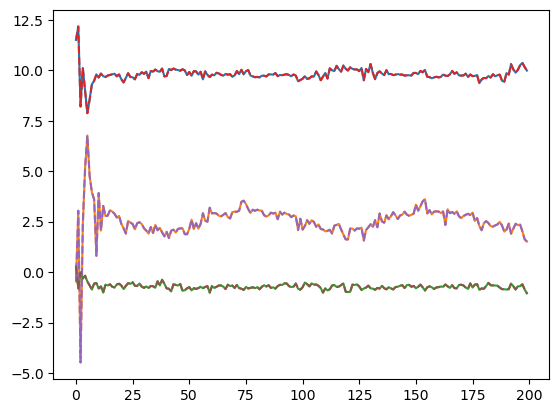

In [4]:
X,y=genDataSet(True,True,servos=True)
plt.plot(y[0:200])
X_,y_=gen_temporal_data(X,y,60)
plt.plot(y_[0:200],"--")
plt.show()

In [5]:
print(len(X))

101413


### Regression

(31333, 32) (31333, 3)
Mean Squared Error: 0.23708


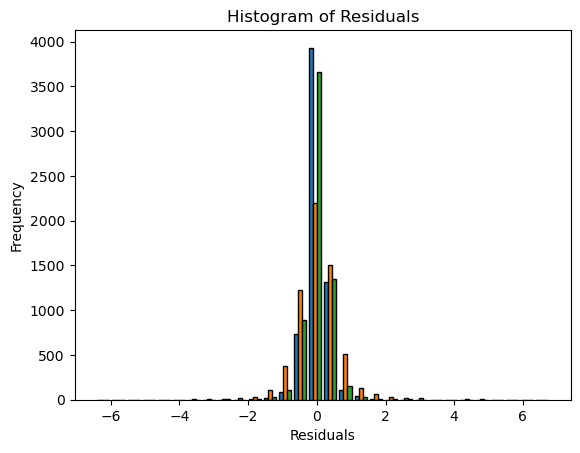

In [7]:
X,y=genDataSet(0,0,servos=0)
X_,y_=gen_temporal_data(X,y,80)

X_train, X_test, Y_train, Y_test = train_test_split_norm(X_, y_, test_size=0.2, random_state=42)
#X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

pred=ridge_model.predict(X_test)

#make label for slope interval

# Assuming 'actual_values' and 'predicted_values' are your actual and predicted tilt values
# Calculate the residuals
residuals = Y_test - pred

plt.hist(residuals, bins=30, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [12]:
joblib.dump(model, 'linear_regression_model.pkl')

# Check the file size of the saved model
file_size = os.path.getsize('linear_regression_model.pkl')
print("Size of the saved model file: {:.2f} KB".format(file_size / 1024))


Size of the saved model file: 2723.57 KB


(83358, 34) (58106, 3)
Time taken 1707324285.175712


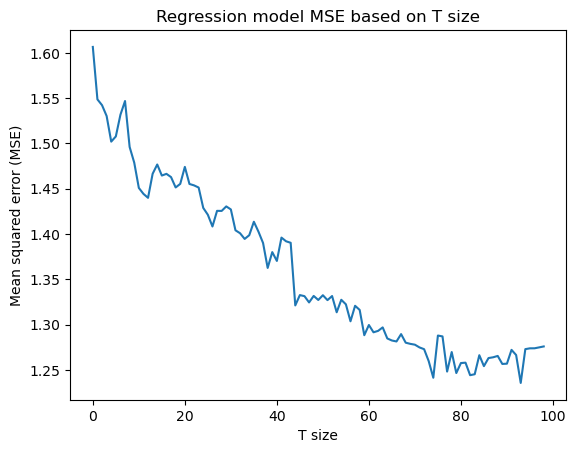

(1.3274936678165095, 1.606520310330778, 1.235744978782542, 1.3580455005308578)

In [60]:
losses_a=[]
X,y=genDataSet(0,1,ramp=0,servos=1)
t=time.time()
for t in range(1,100):
    X_,y_=gen_temporal_data(X,y,t)
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_test)

    # Calculate Mean Squared Error (MSE) to evaluate the model
    mse = mean_squared_error(Y_test, Y_pred)
    losses_a.append(mse)
print("Time taken",time.time()-t)
plt.plot(losses_a)
plt.title("Regression model MSE based on T size")
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("T size")
plt.show()
np.median(losses_a),np.max(losses_a),np.min(losses_a),np.average(losses_a)

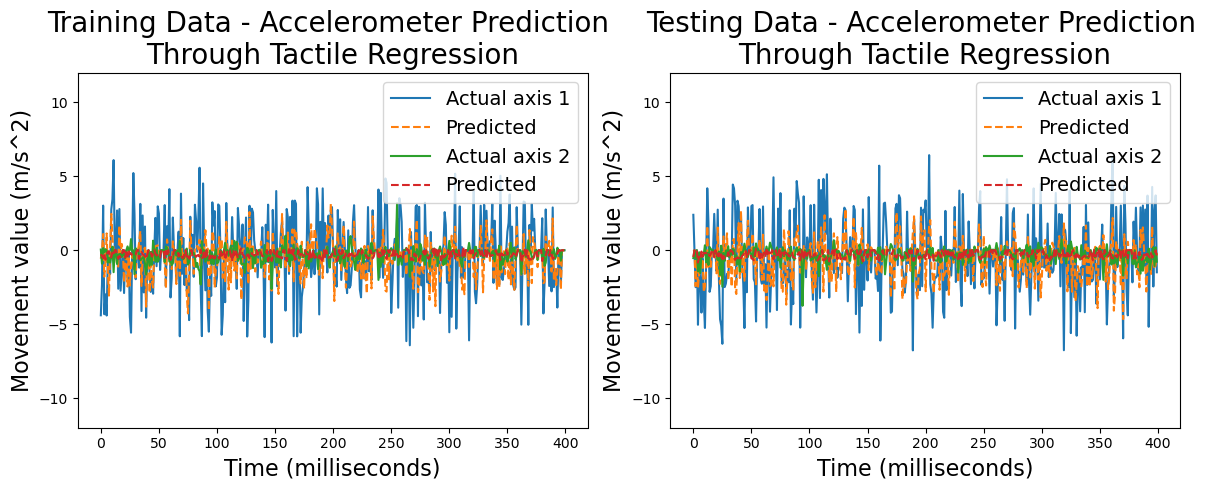

In [8]:
start = 0
end = 400
axis = 1

# Plot for Training Data
Y_pred_train = ridge_model.predict(X_train)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1 - Training Data
axs[0].plot(Y_train[:, axis][start:end], label="Actual axis 1")
axs[0].plot(Y_pred_train[:, axis][start:end], "--", label="Predicted")
axs[0].plot(Y_train[:, axis + 1][start:end], label="Actual axis 2")
axs[0].plot(Y_pred_train[:, axis + 1][start:end], "--", label="Predicted")

axs[0].set_ylim([-12,12])
axs[0].set_title("Training Data - Accelerometer Prediction \nThrough Tactile Regression", fontsize=20)
axs[0].set_ylabel("Movement value (m/s^2)", fontsize=16)
axs[0].set_xlabel("Time (milliseconds)", fontsize=16)
axs[0].legend(loc="upper right", fontsize=14)

# Plot for Testing Data
Y_pred_test = ridge_model.predict(X_test)

# Subplot 2 - Testing Data
axs[1].plot(Y_test[:, axis][start:end], label="Actual axis 1")
axs[1].plot(Y_pred_test[:, axis][start:end], "--", label="Predicted")
axs[1].plot(Y_test[:, axis + 1][start:end], label="Actual axis 2")
axs[1].plot(Y_pred_test[:, axis + 1][start:end], "--", label="Predicted")

axs[1].set_ylim([-12,12])
axs[1].set_title("Testing Data - Accelerometer Prediction \nThrough Tactile Regression", fontsize=20)
axs[1].set_ylabel("Movement value (m/s^2)", fontsize=16)
axs[1].set_xlabel("Time (milliseconds)", fontsize=16)
axs[1].legend(loc="upper right", fontsize=14)

plt.tight_layout()
plt.show()


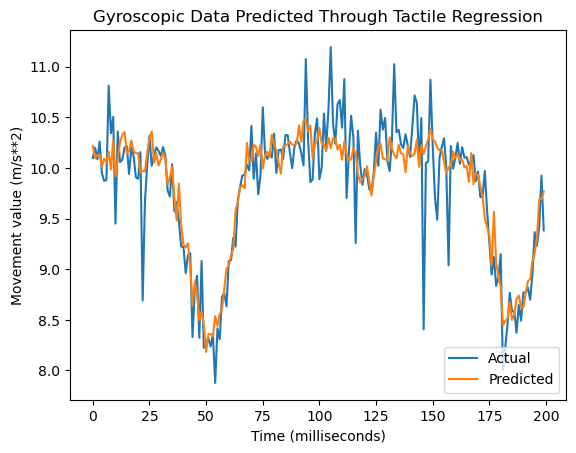

In [39]:
Y_pred = ridge_model.predict(X_test)
plt.plot(Y_test[:,0][0:200],label="Actual")
plt.plot(Y_pred[:,0][0:200],label="Predicted")


plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value (m/s**2)")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()


#### Without vibration

(101413, 34) (76161, 3)
Mean Squared Error: 1.75299


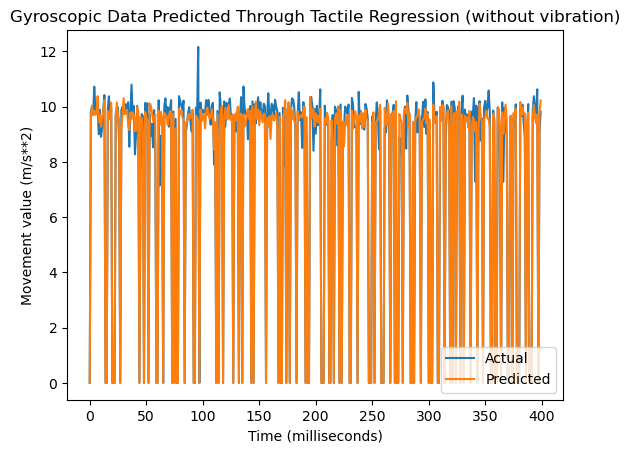

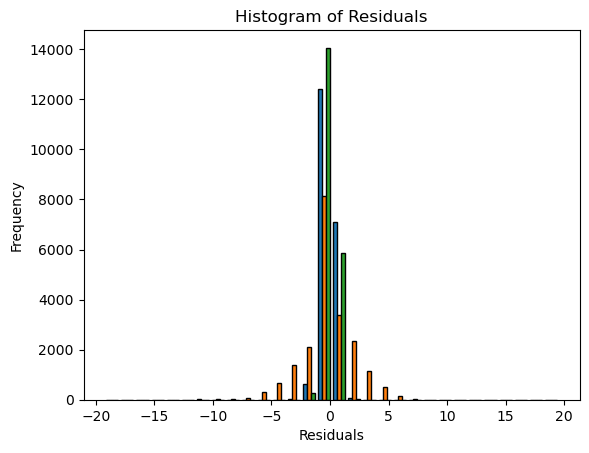

In [5]:
X,y=genDataSet(False,True,servos=1)
X_,y_=gen_temporal_data(X,y,60)
X_train, X_test, Y_train, Y_test = train_test_split(X_,y_, test_size=0.2, random_state=42) #_norm for better plot
start = 0
end = 400
axis = 1
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

Y_pred = ridge_model.predict(X_train)
plt.plot(Y_train[:,0][start:end],label="Actual")
plt.plot(Y_pred[:,0][start:end],label="Predicted")

plt.title("Gyroscopic Data Predicted Through Tactile Regression (without vibration)")
plt.ylabel("Movement value (m/s**2)")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()


pred=ridge_model.predict(X_test)

#make label for slope interval

# Assuming 'actual_values' and 'predicted_values' are your actual and predicted tilt values
# Calculate the residuals
residuals = Y_test - pred

# Create a histogram of residuals
plt.hist(residuals, bins=30, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Time taken 1707158349.224684


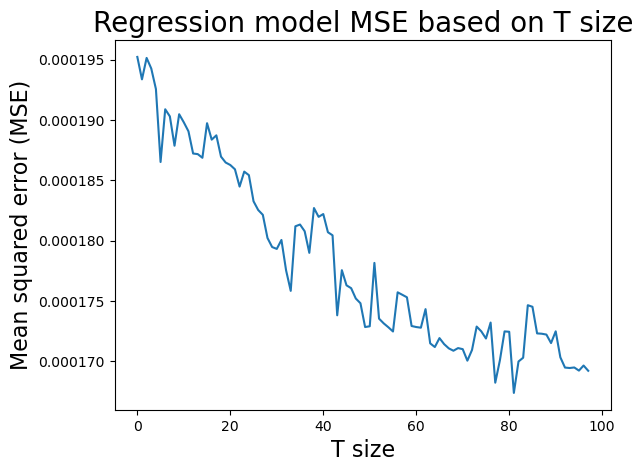

In [6]:
losses_b=[]
t=time.time()
for t in range(1,100):
    X_,y_=gen_temporal_data(X,y,t)
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_test)

    # Calculate Mean Squared Error (MSE) to evaluate the model
    mse = mean_squared_error(Y_test, Y_pred)
    losses_b.append(mse/10000)
print("Time taken",time.time()-t)
plt.plot(losses_b[1:])
plt.title("Regression model MSE based on T size",fontsize=20)
plt.ylabel("Mean squared error (MSE)",fontsize=16)
plt.xlabel("T size",fontsize=16)
plt.show()

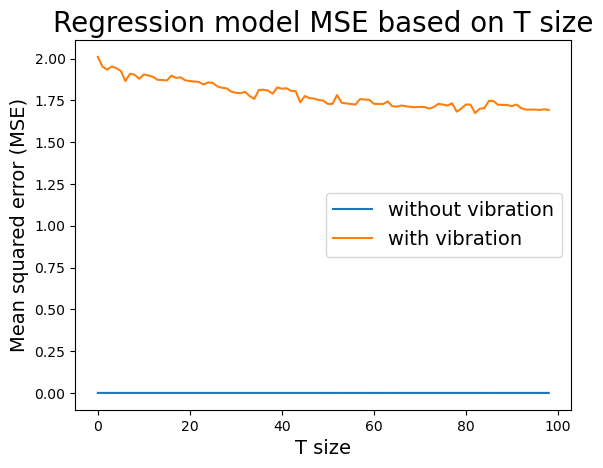

In [13]:
plt.plot(losses_b,label="without vibration")
plt.plot(losses_a,label="with vibration")
plt.title("Regression model MSE based on T size",fontsize=20)
plt.ylabel("Mean squared error (MSE)",fontsize=14)
plt.xlabel("T size",fontsize=14)
plt.legend(loc="center right",fontsize=14)
plt.show()

In [ ]:
np.median(losses_b),np.max(losses_b),np.min(losses_b),np.average(losses_b)

#### Texture study

In [3]:
X,y=genDataSet(False,False,servos=True)
t=100
X_,y_=gen_temporal_data(X,y,t)
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
normal_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
normal_model.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred = normal_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse_norm = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse_norm :.5f}")



mse_texture=getMSEData("carpet_servos_d5_raw_L.csv","carpet_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
mse_concrete=getMSEData("outdoor_servos_d5_raw_L.csv","outdoor_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
mse_outdoor=getMSEData("wood_servos_d5_raw_L.csv","wood_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
print("****************************\n\nNormal MSE:",mse_norm,"\n\nCarpet MSE:",mse_texture,"\n\nConcrete MSE:",mse_concrete,"\n\nOutdoor MSE:",mse_outdoor)




(31333, 34) (31333, 3)
Mean Squared Error: 0.20484
****************************

Normal MSE: 0.20483878066192215 

Carpet MSE: 0.5902376904738494 

Concrete MSE: 0.621076456940982 

Outdoor MSE: 0.1423051172397182


Train model without texture data

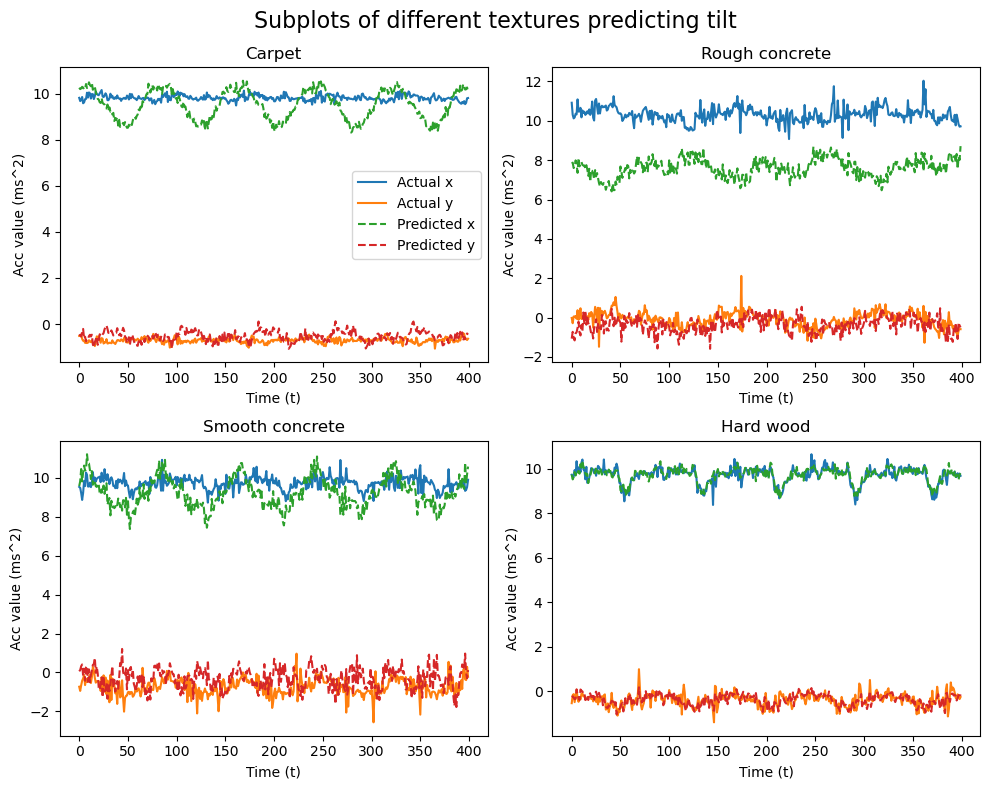

In [4]:
y,yp=getMSEPreds("wood_servos_d5_raw_L.csv","wood_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
yt,ypt=getMSEPreds("carpet_servos_d5_raw_L.csv","carpet_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
yc,ypc=getMSEPreds("servos_rough_raw_L.csv","servos_rough_raw_R.csv",normal_model,0,t,servos=True)
yo,ypo=getMSEPreds("outdoor_servos_d5_raw_L.csv","outdoor_servos_d5_raw_R.csv",normal_model,0,t,servos=True)

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=[0,2]
start=2000
show=2400
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label=["Actual x","Actual y"])
axs[0, 0].plot(ypt[start:show,axis],"--",label=["Predicted x","Predicted y"])
axs[0, 0].set_title('Carpet')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value (ms^2)')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value (ms^2)')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value (ms^2)')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value (ms^2)')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()

Model trained on all textures

In [5]:
X,y=genDataSet(False,True,servos=1)
t=100
X_,y_=gen_temporal_data(X,y,t)
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
normal_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
normal_model.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred = normal_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse_norm = mean_squared_error(Y_test, Y_pred)
y,yp=getMSEPreds("wood_servos_d5_raw_L.csv","wood_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
yt,ypt=getMSEPreds("carpet_servos_d5_raw_L.csv","carpet_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
yc,ypc=getMSEPreds("servos_rough_raw_L.csv","servos_rough_raw_R.csv",normal_model,0,t,servos=True)
yo,ypo=getMSEPreds("outdoor_servos_d5_raw_L.csv","outdoor_servos_d5_raw_R.csv",normal_model,0,t,servos=True)


mse_texture=getMSEData("carpet_servos_d5_raw_L.csv","carpet_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
mse_concrete=getMSEData("outdoor_servos_d5_raw_L.csv","outdoor_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
mse_outdoor=getMSEData("wood_servos_d5_raw_L.csv","wood_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
print("****************************\nNormal MSE:",mse_norm,"\nCarpet MSE:",mse_texture,"\nConcrete MSE:",mse_concrete,"\nOutdoor MSE:",mse_outdoor)



(106863, 34) (81611, 3)
****************************
Normal MSE: 1.7906409055781902 
Carpet MSE: 4.533136763314204 
Concrete MSE: 7.000551228336665 
Outdoor MSE: 5.606096051421932


9284


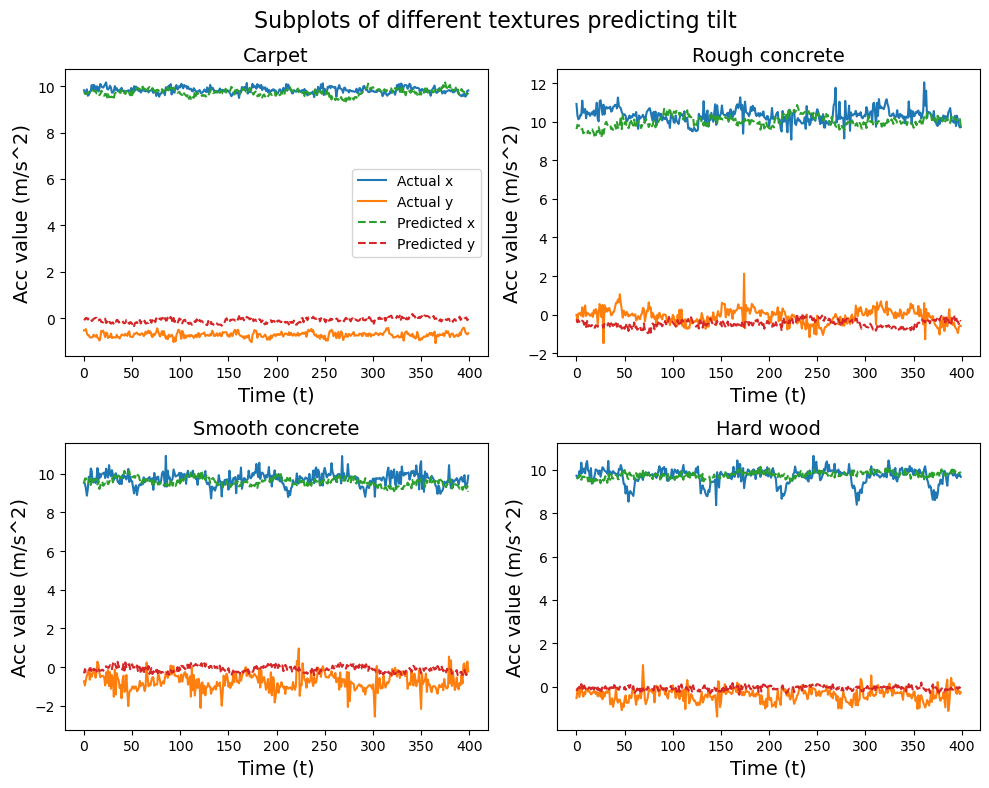

In [8]:
# Creating subplots
print(len(yt))
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=[0,2]
start=2000
show=2400
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label=["Actual x","Actual y"])
axs[0, 0].plot(ypt[start:show,axis],"--",label=["Predicted x","Predicted y"])
axs[0, 0].set_title('Carpet', fontsize=14)
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)', fontsize=14)
axs[0, 0].set_ylabel('Acc value (m/s^2)', fontsize=14)

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete', fontsize=14)
axs[0, 1].set_xlabel('Time (t)', fontsize=14)
axs[0, 1].set_ylabel('Acc value (m/s^2)', fontsize=14)

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete', fontsize=14)
axs[1, 0].set_xlabel('Time (t)', fontsize=14)
axs[1, 0].set_ylabel('Acc value (m/s^2)', fontsize=14)

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood', fontsize=14)
axs[1, 1].set_xlabel('Time (t)', fontsize=14)
axs[1, 1].set_ylabel('Acc value (m/s^2)', fontsize=14)

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()

##### All models


In [13]:
X,y=genDataSet(True,texture=True,servos=True)

t=100
X_,y_=gen_temporal_data(X,y,t)
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
uber_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
uber_model.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred = uber_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse_norm = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

y,yp=getMSEPreds("wood_servos_d5_raw_L.csv","wood_servos_d5_raw_R.csv",uber_model,0,t) #normal
yt,ypt=getMSEPreds("carpet_servos_d5_raw_raw_L.csv","carpet_servos_d5_raw_R.csv",uber_model,0,t) #carpet
yc,ypc=getMSEPreds("outdoor_servos_d5_raw_L.csv","outdoor_servos_d5_raw_R.csv",uber_model,0,t) #concrete
yo,ypo=getMSEPreds("servos_rough_raw_L.csv","servos_rough_raw_R.csv",uber_model,0,t) #outdoor

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=[1,2]
start=100
show=300
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label=["Actual x","Actual y"])
axs[0, 0].plot(ypt[start:show,axis],"--",label=["Predicted x","Predicted y"])
axs[0, 0].set_title('Carpet', fontsize=20)
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value (m/s**2)')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete', fontsize=20)
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value (m/s**2)')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete', fontsize=20)
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value (m/s**2)')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood', fontsize=20)
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value (m/s**2)')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=22)

plt.tight_layout()

# Displaying the plots
plt.show()
mse_texture=getMSEData("carpet_servos_d5_raw_L.csv","carpet_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
mse_concrete=getMSEData("outdoor_servos_d5_raw_L.csv","outdoor_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
mse_outdoor=getMSEData("wood_servos_d5_raw_L.csv","wood_servos_d5_raw_R.csv",normal_model,0,t,servos=True)
print("****************************\n\nNormal MSE:",mse_norm,"\n\nCarpet MSE:",mse_texture,"\n\nConcrete MSE:",mse_concrete,"\n\nOutdoor MSE:",mse_outdoor)

(106863, 32) (81611, 3)
Mean Squared Error: 0.23708


NameError: name 'normal_model' is not defined

##### Other classifiers
###### Random forest regressor

(101413, 34) (76161, 3)
(81066, 2720) (81066, 3)
Mean Squared Error: 0.84441


ValueError: X has 2720 features, but Ridge is expecting 2040 features as input.

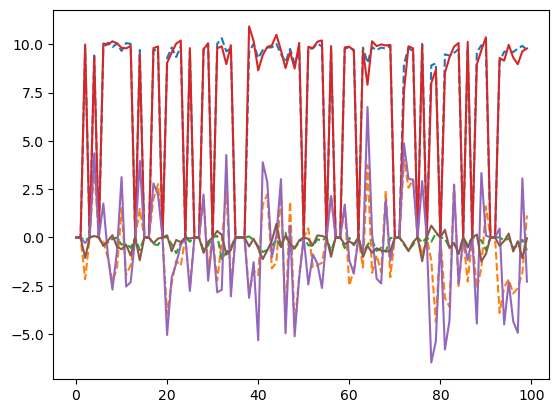

In [49]:
X,y=genDataSet(0,1,servos=True)
#X,y=getAugmentedData(X,y)
t=80
X_,y_=gen_temporal_data(X,y,t)
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
uber_model=RandomForestRegressor(n_estimators=50, random_state=42)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
print(X_train.shape, Y_train.shape)
uber_model.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred = uber_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse_norm = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse_norm:.5f}")

Y_pred = uber_model.predict(X_test)
plt.plot(Y_pred[:100,],"--")
plt.plot(Y_test[:100,])
plt.plot()


In [15]:
t=80
y,yp=getMSEPreds("wood_servos_d5_raw_L.csv","wood_servos_d5_raw_R.csv",uber_model,0,t) #normal
yt,ypt=getMSEPreds("carpet_servos_d5_raw_raw_L.csv","carpet_servos_d5_raw_R.csv",uber_model,0,t) #carpet
yc,ypc=getMSEPreds("outdoor_servos_d5_raw_L.csv","outdoor_servos_d5_raw_R.csv",uber_model,0,t) #concrete
yo,ypo=getMSEPreds("servos_rough_raw_L.csv","servos_rough_raw_R.csv",uber_model,0,t) #outdoor

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=[0,1]
start=200
show=400
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label=["Actual z","Actual y"])
axs[0, 0].plot(ypt[start:show,axis],"--",label=["Predicted z","Predicted y"])
axs[0, 0].set_title('Carpet')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value (m/s**2)')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value (m/s**2)')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value (m/s**2)')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value (m/s**2)')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()
mse_texture=getMSEData("carpet_d1.1_raw_L.csv","carpet_d1.1_raw_R.csv",uber_model,0,t)
mse_concrete=getMSEData("wood_d1_raw_L.csv","wood_d1_raw_R.csv",uber_model,0,t)
mse_outdoor=getMSEData("carpet_d1.1_raw_L.csv","carpet_d1.1_raw_R.csv",uber_model,0,t)
print("****************************\n\nNormal MSE:",mse_norm,"\n\nCarpet MSE:",mse_texture,"\n\nConcrete MSE:",mse_concrete,"\n\nOutdoor MSE:",mse_outdoor)

ValueError: X has 2560 features, but Ridge is expecting 3200 features as input.

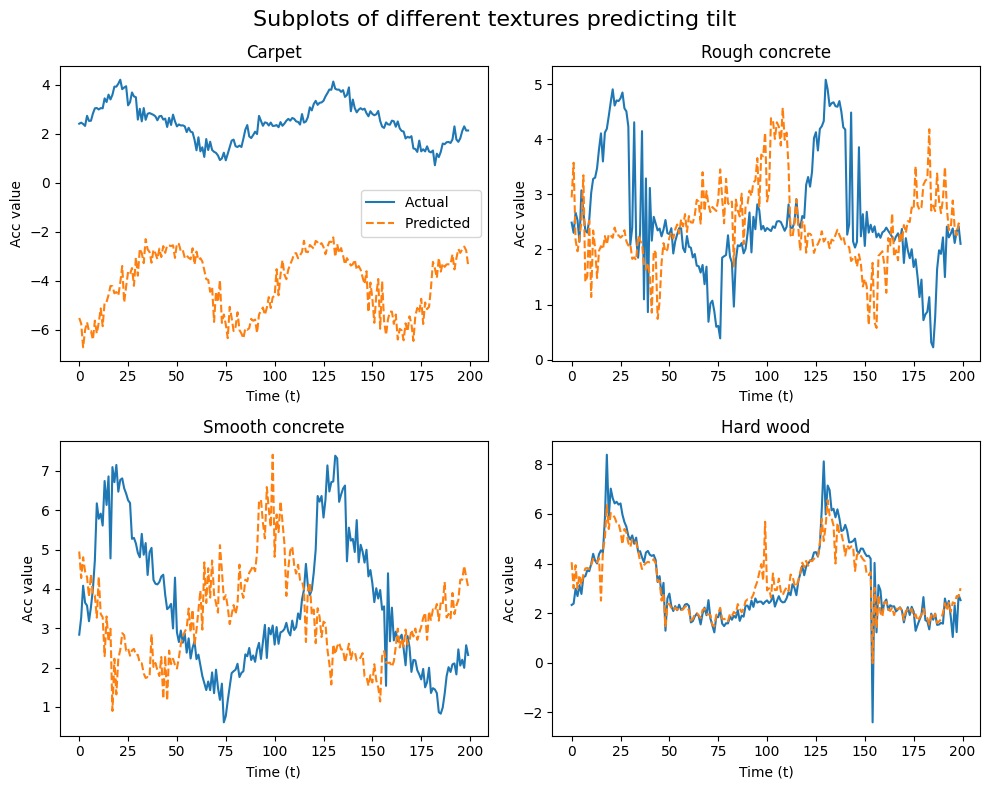

In [19]:
# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=1
start=200
show=400
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label="Actual ")
axs[0, 0].plot(ypt[start:show,axis],"--",label="Predicted ")
axs[0, 0].set_title('Carpet')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value (m/s**2)')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value (m/s**2)')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value (m/s**2)')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value (m/s**2)')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()


In [ ]:
mse=[]
for i in range(1,50):

    test_model=RandomForestRegressor(n_estimators=i, random_state=42)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    print(X_train.shape, Y_train.shape)
    test_model.fit(X_train, Y_train)
    # Make predictions on the test data
    Y_pred = test_model.predict(X_test)
    y=getMSEData("accmovementLeftFoot.csv","accmovementRightFoot.csv",test_model,t)
    yt=getMSEData("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",test_model,t)
    yc=getMSEData("accmovementLeftFootConrete.csv","accmovementRightFootConrete.csv",test_model,t)
    yo=getMSEData("accmovementLeftFootOutdoor.csv","accmovementRightFootOutdoor.csv",test_model,t)
    mse.append([y,yt,yc,yo])
    print(i,mse[-1])

mse=np.array(mse)
x=[i for i in range(1,50)]
plt.plot(x,mse[:,0],label="Hard wood")
plt.plot(x,mse[:,1],label="Carpet")
plt.plot(x,mse[:,2],label="Rough concrete")
plt.plot(x,mse[:,3],label="Smoth concrete")
plt.title("How MSE is influenced by number of estimators")
plt.ylabel("Mean squared error")
plt.xlabel("N estimator size")
plt.legend(loc="lower right")
plt.plot()

###### Neural network

In [4]:

# Define a simple neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, hidden_size2=None):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.2)
        self.fc2=None
        if type(hidden_size2)!=type(None):
            self.fc2 = nn.Linear(hidden_size,hidden_size2)
            self.relu2 = nn.ReLU()
            self.fco = nn.Linear(hidden_size2, output_size)
        else:
            self.fco = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        #self.dropout(x)
        if type(self.fc2)!=type(None):
            x = self.fc2(x)
            x = self.relu2(x)
        x = self.fco(x)
        return x

# Define some training data
X,y=genDataSet(0,0,ramp=0,servos=1)
y=y[:,[0,2]]
X_,y_=gen_temporal_data(X,y,20)
scaler = StandardScaler()
X_ = scaler.fit_transform(X_) #scale data

X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

CUT=4000

X_train = torch.tensor(X_train[0:CUT], dtype=torch.float32).to(device)
X_test = torch.tensor(X_test[0:CUT], dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train[0:CUT], dtype=torch.float32).to(device)
Y_test = torch.tensor(Y_test[0:CUT], dtype=torch.float32).to(device)
# Initialize the neural network, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = int(X_train.shape[1]*1.5)
output_size = Y_test.shape[1]

print("Training...",hidden_size)
model = SimpleNN(input_size, hidden_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
batch_size=64
# Training loop
epochs = 1000
for epoch in range(epochs):
    # Forward pass
    for batch in range(0,len(X_train)-batch_size,batch_size):
        outputs = model(X_train[batch:batch+batch_size])
        loss = criterion(outputs, Y_train[batch:batch+batch_size])
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
    
    # Print progress
    if (epoch) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')



(31333, 34) (31333, 3)
Training... 1020
Epoch [1/1000], Loss: 14.9216
Epoch [11/1000], Loss: 0.5400
Epoch [21/1000], Loss: 0.1839
Epoch [31/1000], Loss: 0.1316
Epoch [41/1000], Loss: 0.1036
Epoch [51/1000], Loss: 0.0843
Epoch [61/1000], Loss: 0.0688
Epoch [71/1000], Loss: 0.0563
Epoch [81/1000], Loss: 0.0464
Epoch [91/1000], Loss: 0.0383
Epoch [101/1000], Loss: 0.0317
Epoch [111/1000], Loss: 0.0264
Epoch [121/1000], Loss: 0.0220
Epoch [131/1000], Loss: 0.0182
Epoch [141/1000], Loss: 0.0153
Epoch [151/1000], Loss: 0.0130
Epoch [161/1000], Loss: 0.0113
Epoch [171/1000], Loss: 0.0100
Epoch [181/1000], Loss: 0.0088
Epoch [191/1000], Loss: 0.0080
Epoch [201/1000], Loss: 0.0073
Epoch [211/1000], Loss: 0.0068
Epoch [221/1000], Loss: 0.0064
Epoch [231/1000], Loss: 0.0061
Epoch [241/1000], Loss: 0.0057
Epoch [251/1000], Loss: 0.0055
Epoch [261/1000], Loss: 0.0053
Epoch [271/1000], Loss: 0.0051
Epoch [281/1000], Loss: 0.0051
Epoch [291/1000], Loss: 0.0050
Epoch [301/1000], Loss: 0.0049
Epoch [31

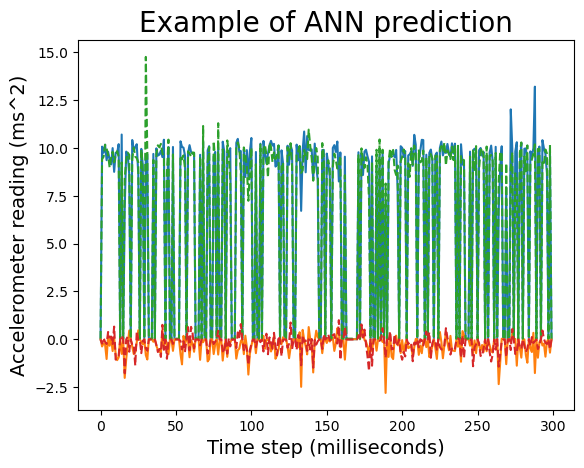

In [65]:
show=X_test[100:400]
predictions = model(show)
#show=((show*std) + mean).cpu().detach().numpy() #uncompress
plt.plot(Y_test[100:400].cpu().detach().numpy())
plt.plot(predictions[:].cpu().detach().numpy(),"--")
plt.title("Example of ANN prediction", fontsize=20)
plt.xlabel("Time step (milliseconds)", fontsize=14)
plt.ylabel("Accelerometer reading (ms^2)", fontsize=14)
plt.show()

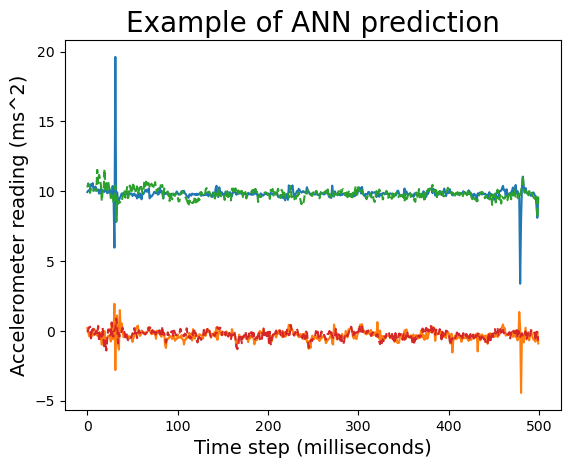

In [5]:
sample=X_[6000:6500]
sample_y=y[6000:6500]
predictions=model.forward(torch.tensor(sample, dtype=torch.float32).to(device))
plt.plot(sample_y[:,])
plt.plot(predictions.cpu().detach().numpy(),"--")
plt.title("Example of ANN prediction", fontsize=20)
plt.xlabel("Time step (milliseconds)", fontsize=14)
plt.ylabel("Accelerometer reading (ms^2)", fontsize=14)
plt.show()

In [6]:
def calculate_memory_usage(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_memory = total_params * 4  # Assuming 32-bit floating-point numbers (float32)
    total_memory_in_mb = total_memory / (1024 ** 2)  # Convert bytes to megabytes
    return total_memory_in_mb

calculate_memory_usage(model)

2.6575546264648438

Hyperparameter T size experiment

In [68]:
losses=[]

trials=5
for t in range(1,50,2):
    print("T size",t)
    # Define some training data
    mse=0
    for trial in range(trials):
        print("\t Trial... ",trial)
        X,y=genDataSet(0,0,servos=1)
        y=y[:,[0,2]]
        X_,y_=gen_temporal_data(X,y,t)
        scaler = StandardScaler()
        X_ = scaler.fit_transform(X_) #scale data

        X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
        X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
        X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
        Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
        Y_test = torch.tensor(Y_test, dtype=torch.float32).to(device)
        # Initialize the neural network, loss function, and optimizer
        input_size = X_train.shape[1]
        hidden_size = int(X_train.shape[1]*1.5)
        output_size = Y_test.shape[1]

        model = SimpleNN(input_size, hidden_size, output_size).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        batch_size=64
        # Training loop
        epochs = 500
        for epoch in range(epochs):
            # Forward pass
            for batch in range(0,len(X_train)-batch_size,batch_size):
                outputs = model(X_train[batch:batch+batch_size])
                loss = criterion(outputs, Y_train[batch:batch+batch_size])
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
                optimizer.step()
            
            # Print progress
            if (epoch) % 500 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        predictions = model(X_test[100:600])
        mse += mean_squared_error(predictions.cpu().detach().numpy(), Y_test[100:600].cpu().detach().numpy())

    losses.append(mse/trials)

print("Time taken",time.time()-t)
plt.plot(list(range(1,50,2)),losses)
plt.title("Regression model MSE based on T size", fontsize=20)
plt.ylabel("Mean squared error (MSE)", fontsize=14)
plt.xlabel("T size", fontsize=14)
plt.show()



T size 1
	 Trial...  0
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.5338
	 Trial...  1
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.5976
	 Trial...  2
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.6414
	 Trial...  3
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.7326
	 Trial...  4
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.4949
T size 3
	 Trial...  0
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.4421
	 Trial...  1
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.4565
	 Trial...  2
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.4477
	 Trial...  3
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.4986
	 Trial...  4
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.4986
T size 5
	 Trial...  0
(31333, 34) (31333, 3)
Training...
Epoch [1/500], Loss: 0.3902


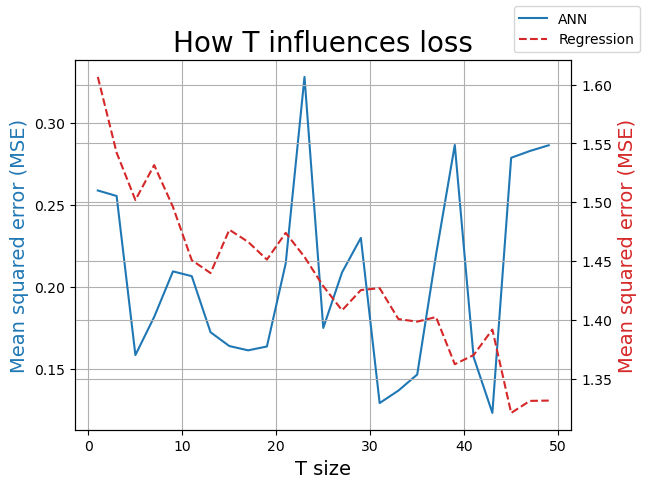

In [61]:
import matplotlib.pyplot as plt

# Generate some sample data
x = range(25)
y1 = [i * 2 for i in x]  # Data for the first y-axis
y2 = [i ** 2 for i in x]  # Data for the second y-axis

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot the first dataset on the left y-axis
ax1.plot(list(range(1,50,2)),losses, color='tab:blue',label="ANN")
ax1.set_xlabel("T size", fontsize=14)
ax1.set_ylabel("Mean squared error (MSE)", color='tab:blue', fontsize=14)

# Create a twin axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the second dataset on the right y-axis
ar=np.array(losses_a)
ar=[]
for i in range(1,50,2):
    ar.append(losses_a[i-1])
ax2.plot(list(range(1,50,2)), ar,"--", color='tab:red',label="Regression")
ax2.set_ylabel("Mean squared error (MSE)", color='tab:red', fontsize=14)

# Add gridlines for both axes
ax1.grid(True)
ax2.grid(True)
ax1.set_title("How T influences loss", fontsize=20)
fig.legend(loc="upper right")
plt.show()


Texture

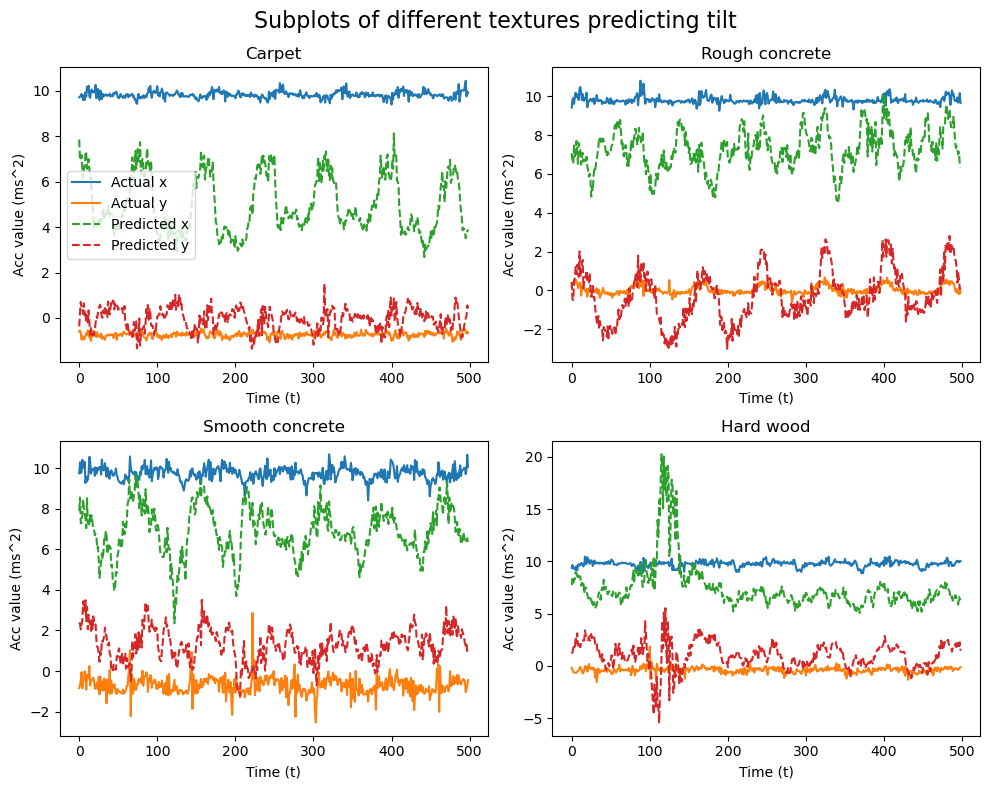

In [66]:
t=20
y,yp=getMSEPredsNN("wood_servos_d5_raw_L.csv","wood_servos_d5_raw_R.csv",model,0,t,servos=True)
yt,ypt=getMSEPredsNN("carpet_servos_d5_raw_L.csv","carpet_servos_d5_raw_R.csv",model,0,t,servos=True)
yc,ypc=getMSEPredsNN("servos_rough_raw_L.csv","servos_rough_raw_R.csv",model,0,t,servos=True)
yo,ypo=getMSEPredsNN("outdoor_servos_d5_raw_L.csv","outdoor_servos_d5_raw_R.csv",model,0,t,servos=True)

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axis=[0,2]
start=0
show=-1
# Plotting each set of x and y data on separate subplots
axs[0, 0].plot(yt[start:show,axis],label=["Actual x","Actual y"])
axs[0, 0].plot(ypt[start:show,axis],"--",label=["Predicted x","Predicted y"])
axs[0, 0].set_title('Carpet')
axs[0, 0].legend()
axs[0, 0].set_xlabel('Time (t)')
axs[0, 0].set_ylabel('Acc value (ms^2)')

axs[0, 1].plot(yc[start:show,axis])
axs[0, 1].plot(ypc[start:show,axis],"--")
axs[0, 1].set_title('Rough concrete')
axs[0, 1].set_xlabel('Time (t)')
axs[0, 1].set_ylabel('Acc value (ms^2)')

axs[1, 0].plot(yo[start:show,axis])
axs[1, 0].plot(ypo[start:show,axis],"--")
axs[1, 0].set_title('Smooth concrete')
axs[1, 0].set_xlabel('Time (t)')
axs[1, 0].set_ylabel('Acc value (ms^2)')

axs[1, 1].plot(y[start:show,axis])
axs[1, 1].plot(yp[start:show,axis],"--")
axs[1, 1].set_title('Hard wood')
axs[1, 1].set_xlabel('Time (t)')
axs[1, 1].set_ylabel('Acc value (ms^2)')

# Adding a central title
plt.suptitle('Subplots of different textures predicting tilt', fontsize=16)

plt.tight_layout()

# Displaying the plots
plt.show()

In [16]:
mean_squared_error(predictions.cpu().detach().numpy(), Y_test[100:600].cpu().detach().numpy())

0.23398687

#### Servos vs non servos

In [16]:
X,y=genDataSet(0,1,servos=0)
X_,y_=gen_temporal_data(X,y,60)

X_train, X_test, Y_train, Y_test = train_test_split_norm(X_, y_, test_size=0.2, random_state=42)
#X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error no servos: {mse:.5f}")

X,y=genDataSet(0,1,servos=1)
X_,y_=gen_temporal_data(X,y,60)

X_train, X_test, Y_train, Y_test = train_test_split_norm(X_, y_, test_size=0.2, random_state=42)
#X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error with servpos: {mse:.5f}")


(101413, 32) (76161, 3)
Mean Squared Error no servos: 0.00046
(101413, 34) (76161, 3)
Mean Squared Error with servpos: 0.00043


(101413, 32) (76161, 3)
(3382, 1920) (81082, 1920)
(101413, 34) (76161, 3)
3.933492070425731 1.7725887353801424


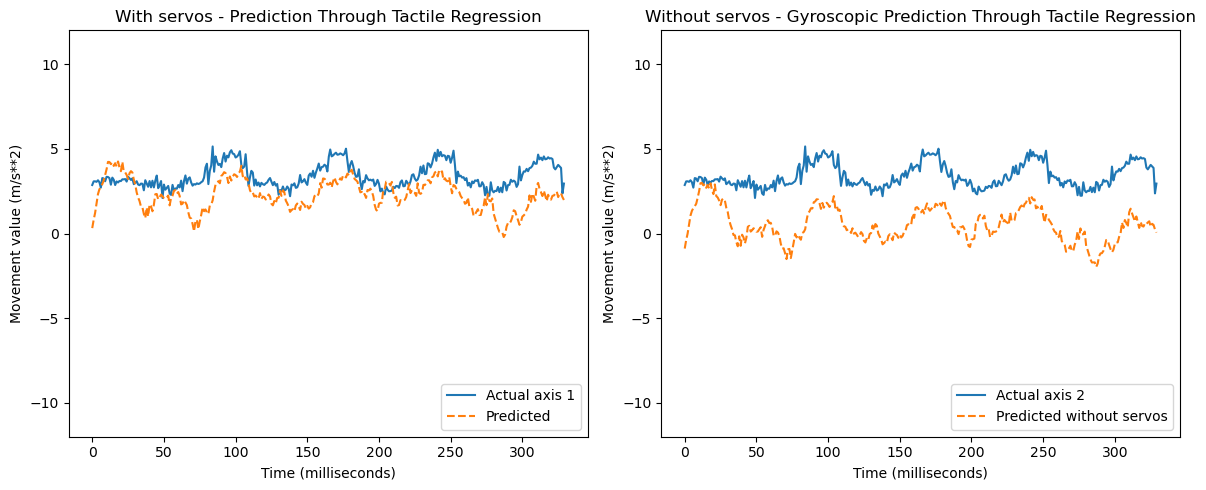

In [40]:
#get ramp data
X,y=sort_data("Smooth_ramp1_d5_raw_L.csv",0,servos=0)
X1,y1=sort_data("Smooth_ramp1_d5_raw_R.csv",0,servos=0)
X_ramp=np.concatenate((X,X1),axis=0)
y_ramp=np.concatenate((y,y1),axis=0)
X_ramp1,y_ramp1=gen_temporal_data(X,y,60)

X,y=sort_data("Smooth_ramp1_d5_raw_L.csv",0,servos=1)
X1,y1=sort_data("Smooth_ramp1_d5_raw_R.csv",0,servos=1)
X_ramp=np.concatenate((X,X1),axis=0)
y_ramp=np.concatenate((y,y1),axis=0)
X_ramp2,y_ramp2=gen_temporal_data(X,y,60)

#train without servos
X,y=genDataSet(0,1,ramp=1,servos=0)
X_,y_=gen_temporal_data(X,y,60)

X_train, X_test, Y_train, Y_test = train_test_split_norm(X_, y_, test_size=0.2, random_state=42)
#X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_modelns = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_modelns.fit(X_train, Y_train)
print(X_ramp1.shape,X_train.shape)
# Make predictions on the test data
Y_pred1 = ridge_modelns.predict(X_ramp1)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse1 = mean_squared_error(y_ramp1, Y_pred1)

#train with servos
X,y=genDataSet(0,1,ramp=1,servos=1)
X_,y_=gen_temporal_data(X,y,60)

X_train, X_test, Y_train, Y_test = train_test_split_norm(X_, y_, test_size=0.2, random_state=42)
#X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_models = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_models.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred2 = ridge_models.predict(X_ramp2)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse2 = mean_squared_error(y_ramp2, Y_pred2)

print(mse1,mse2)
start = 270
end = 600
axis = 1
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1 - Training Data
axs[0].plot(y_ramp[:, axis][start:end], label="Actual axis 1")
axs[0].plot(Y_pred2[:, axis][start:end], "--", label="Predicted")

axs[0].set_ylim([-12,12])
axs[0].set_title("With servos - Prediction Through Tactile Regression")
axs[0].set_ylabel("Movement value (m/s**2)")
axs[0].set_xlabel("Time (milliseconds)")
axs[0].legend(loc="lower right")

# Subplot 2 - Testing Data
axs[1].plot(y_ramp[:, axis][start:end], label="Actual axis 2")
axs[1].plot(Y_pred1[:, axis][start:end], "--", label="Predicted without servos")

axs[1].set_ylim([-12,12])
axs[1].set_title("Without servos - Gyroscopic Prediction Through Tactile Regression")
axs[1].set_ylabel("Movement value (m/s**2)")
axs[1].set_xlabel("Time (milliseconds)")
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()




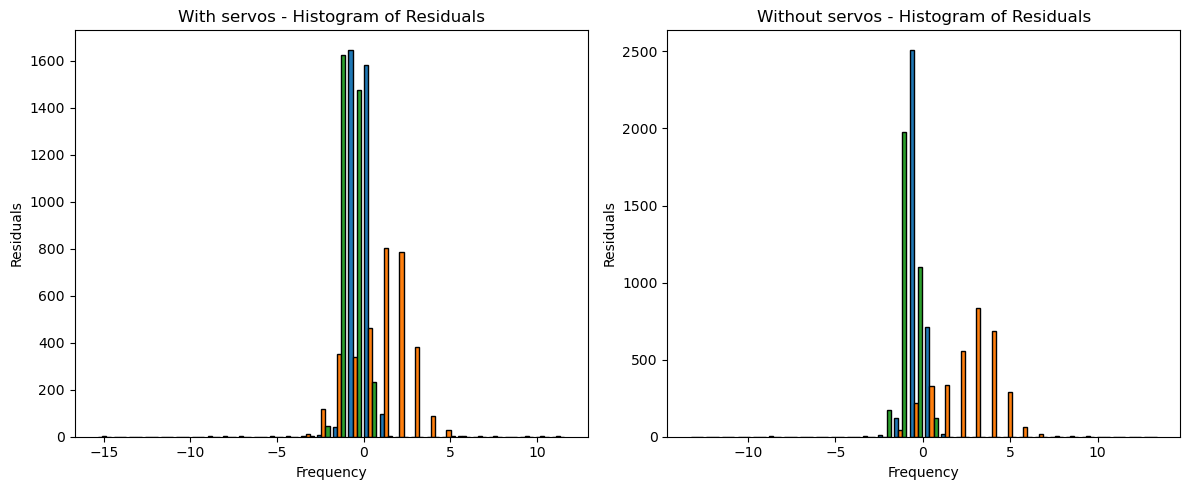

In [47]:

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
bin=30
residuals = y_ramp2-Y_pred2
axs[0].hist(residuals, bins=bin, edgecolor='black')  # You can adjust the number of bins as needed
axs[0].set_title("With servos - Histogram of Residuals")
axs[0].set_ylabel('Residuals')
axs[0].set_xlabel('Frequency')


residuals = y_ramp1-Y_pred1
axs[1].hist(residuals, bins=bin, edgecolor='black')  # You can adjust the number of bins as needed
axs[1].set_title("Without servos - Histogram of Residuals")
axs[1].set_ylabel('Residuals')
axs[1].set_xlabel('Frequency')


plt.tight_layout()
plt.show()

In [49]:

bin_count = 10

# Compute histograms without plotting
residuals1 = y_ramp2 - Y_pred2
hist1, bin_edges1 = np.histogram(residuals1, bins=bin_count)

residuals2 = y_ramp1 - Y_pred1
hist2, bin_edges2 = np.histogram(residuals2, bins=bin_count)

# Print bins and frequencies
print("With servos - Histogram of Residuals:")
for i in range(bin_count):
    print(f"Bin {i + 1}: {bin_edges1[i]:.2f} - {bin_edges1[i + 1]:.2f}\tFrequency: {hist1[i]}",end="")

print("\nWithout servos - Histogram of Residuals:")
for i in range(bin_count):
    print(f"Bin {i + 1}: {bin_edges2[i]:.2f} - {bin_edges2[i + 1]:.2f}\tFrequency: {hist2[i]}",end="")


With servos - Histogram of Residuals:
Bin 1: -15.42 - -12.71	Frequency: 1Bin 2: -12.71 - -10.00	Frequency: 0Bin 3: -10.00 - -7.30	Frequency: 3Bin 4: -7.30 - -4.59	Frequency: 2Bin 5: -4.59 - -1.88	Frequency: 184Bin 6: -1.88 - 0.82	Frequency: 7754Bin 7: 0.82 - 3.53	Frequency: 2071Bin 8: 3.53 - 6.24	Frequency: 121Bin 9: 6.24 - 8.94	Frequency: 6Bin 10: 8.94 - 11.65	Frequency: 4
Without servos - Histogram of Residuals:
Bin 1: -13.38 - -10.69	Frequency: 1Bin 2: -10.69 - -8.01	Frequency: 3Bin 3: -8.01 - -5.33	Frequency: 2Bin 4: -5.33 - -2.64	Frequency: 5Bin 5: -2.64 - 0.04	Frequency: 6169Bin 6: 0.04 - 2.73	Frequency: 2066Bin 7: 2.73 - 5.41	Frequency: 1808Bin 8: 5.41 - 8.10	Frequency: 82Bin 9: 8.10 - 10.78	Frequency: 7Bin 10: 10.78 - 13.46	Frequency: 3

### Bayes classifier

### LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagation
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


#### Prep data

In [ ]:
#prep data
def getData(X,y,T):
    X_,y_=gen_temporal_data_2(X,y,T)
    #reduction
    #X_=(X_-np.average(X_))/np.std(X_)
    #y=(y-np.average(y))/np.std(y)
    #split
    X_train, X_test, Y_train, Y_test = train_test_split(X_.astype(np.float32)[0:100], y_.astype(np.float32)[0:100], test_size=0.2, random_state=42)
    X_train=torch.tensor(X_train).to(device)
    X_test=torch.tensor(X_test).to(device)
    Y_train=torch.tensor(Y_train).to(device)
    Y_test=torch.tensor(Y_test).to(device)
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test=getData(X,y,50)

In [ ]:
# Example usage:
input_size = 32
hidden_size = 64
num_layers = 2
output_size = 3

lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

n = 10
input_data = X_train[0:n]
print(input_data.shape,input_data.dtype)
output = lstm_model(input_data)
print("LSTM Output:", output)

#### Training

In [ ]:
def train(X_train,Y_train,X_test,Y_test,num_epochs = 100,learning_rate = 0.01):
    # Split your dataset into training and validation sets
    # train_data, val_data = ...
    lstm_model=LSTMModel(X_train.shape[2],64,2,Y_train.shape[1]).to(device)
    # Create data loaders for training and validation

    # Initialize the optimizer
    optimizer = optim.SGD(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history_train=[]
    history_test=[]
    # Training loop
    for epoch in range(num_epochs):
        lstm_model.train()

        optimizer.zero_grad()
        # Forward pass
        outputs = lstm_model(X_train)

        # Calculate the loss
        loss = criterion(outputs, Y_train)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss = loss.item()
        history_train.append(total_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

        # Validation
        lstm_model.eval()
        with torch.no_grad():
            total_val_loss = 0

            outputs = lstm_model(X_test)
            val_loss = criterion(outputs, Y_test)
            total_val_loss = val_loss.item()

            print(f"Validation Loss: {total_val_loss:.4f}")
            history_test.append(total_val_loss)
    # Save the trained model
    #torch.save(lstm_model.state_dict(), "lstm_model.pth")
    return history_train, history_test

lossTrain,lossTest=train(X_train,Y_train,X_test,Y_test,num_epochs = 10000,learning_rate = 0.001)

#### Opening data

In [ ]:
X_train, X_test, Y_train, Y_test=getData(X,y,50)
#lstm_model=LSTMModel(X_train.shape[2],50,2,Y_train.shape[1]).to(device)
#lstm_model.load_state_dict(torch.load(path+"GPUCluster/data/lstm_model.pth",map_location=torch.device('cpu')))
outputs = lstm_model(X_train)

plt.plot(outputs[:,0].cpu().detach().numpy(),"--",c="b",label="Prediction x")
plt.plot(Y_train[:,0].cpu().detach().numpy(),c="b",label="Actual x")

plt.plot(outputs[:,1].cpu().detach().numpy(),"--",c="r",label="Prediction y")
plt.plot(Y_train[:,1].cpu().detach().numpy(),c="r",label="Actual y")

plt.plot(outputs[:,2].cpu().detach().numpy(),"--",c="g",label="Prediction z")
plt.plot(Y_train[:,2].cpu().detach().numpy(),c="g",label="Actual z")
plt.xlabel("Time")
plt.ylabel("Analogue value normalised")
plt.title("LSTM prediction vs real gyroscope data")
plt.legend(loc="lower right")
plt.show()
np.average(np.abs(outputs.cpu().detach().numpy()-Y_train.cpu().detach().numpy()))

In [ ]:
ar=[]
std=[]
ar1=[]
std1=[]
for i in range(1,30):
    X_train, X_test, Y_train, Y_test=getData(X,y,i)
    outputs = lstm_model(X_train)
    ar.append(np.average(np.abs(outputs.detach().numpy()-Y_train.detach().numpy())))
    std.append(np.std(outputs.detach().numpy()))
    
    X_,y_=gen_temporal_data(X,y,i)
    y_=y_[:,2]
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_train)

    ar1.append(np.average(np.abs(Y_pred-Y_train)))
    std1.append(np.std(Y_pred))

print(ar)
plt.plot(ar,label="Error LSTM")
plt.plot(std,label="Std LSTM")
plt.plot(ar1,label="Error Regression")
plt.plot(std1,label="Std Regression")
plt.title("How T influences error on different models")
plt.xlabel("T size")
plt.legend(loc="lower right")
plt.show()

In [ ]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ar,c="g",label="LSTM")
ax2.plot(std,c="r",label="Std LSTM")
ax1.plot(ar1,"--",c="g",label="Regression")
ax2.plot(std1,"--",c="r",label="Std Regression")

ax1.set_xlabel('T size')
ax1.set_ylabel('Standrad deviation', color='r')
ax2.set_ylabel('Error', color='g')
ax1.set_title("How T influences error on different models")

ax1.legend(loc="upper left")

### Visualisation 

In [ ]:
from matplotlib.cm import get_cmap
cmap = get_cmap('tab20')  # You can choose different colormaps

filename="train_loss_t="

typ=".npy"
for i in range(1,20):
    shade=i/20
    data=np.load("/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/GPUCluster/data/"+filename+str(i)+"_"+typ)
    plt.plot(data,label="T="+str(i),color="b",alpha=1 - shade)

plt.title("How T influences training of the LSTM model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right",bbox_to_anchor=(1.25, 1.05))
plt.xlim([0,1000])
plt.show()

In [ ]:
X,y=sort_data("accmovementLeftFoot.csv",dir="left")
#X1,y1=sort_data("movementLeftFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)
axis=1
maxsize=1000
colors = np.max(X[0:maxsize],axis=1)
plt.figure(figsize=(10, 5))  # Width: 10 units, Height: 5 units

xx=[i for i in range(maxsize)]
for i in range(len(xx) - 1):
    plt.plot(xx[i:i+2], y[i:i+2,axis], color=plt.cm.Blues(colors[i]))

X1,y1=sort_data("accmovementRightFoot.csv",dir="right")
colors = np.max(X1[0:maxsize],axis=1)
xx=[i for i in range(maxsize,maxsize+maxsize)]
for i in range(len(xx) - 1):
    plt.plot(xx[i:i+2], y1[i:i+2,axis], color=plt.cm.Greens(colors[i]))

plt.title("Accelerometer movements visualised")
plt.xlabel("Time step (t)")
plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='Left foot pressures')
plt.colorbar(plt.cm.ScalarMappable(cmap='Greens'), label='Right foot pressures')
plt.ylabel("Sensor reading")
plt.show()

In [ ]:
dir(plt.cm)

In [ ]:
plt.plot(df['x'][FROM:TO])
plt.plot(df['y'][FROM:TO])
plt.plot(df['z'][FROM:TO])
plt.show()

## Checking whether day affects the data

In [5]:
X,y=sort_data("carpet_d1_raw_R.csv")
#X1,y1=sort_data("movementLeftFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("concrete_d2_raw_R.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

X_,y_=gen_temporal_data(X,y,80) #replace t with whatever the model is trained on
print(X_.shape,y_.shape)
t=80
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
Y_pred = uber_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print("MSE:",mse)

X data: (3600, 32) /ny data: (3600, 3)
X data: (3600, 32) /ny data: (3600, 3)
(7120, 2560) (7120, 3)
MSE: 8.637164857868788


In [6]:
X,y=sort_data("RoughRock_d3_raw_L.csv")
#X1,y1=sort_data("movementLeftFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("Carpet_d4_raw_L.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

X_,y_=gen_temporal_data(X,y,80) #replace t with whatever the model is trained on
print(X_.shape,y_.shape)
t=80
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
Y_pred = uber_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print("MSE:",mse)

X data: (4950, 32) /ny data: (4950, 3)
X data: (4950, 32) /ny data: (4950, 3)
(9820, 2560) (9820, 3)
MSE: 6.726459611345902


In [ ]:
y,yp=getMSEPreds("carpet_d1_raw_R.csv","carpet_d1_raw_R.csv",uber_model,t)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axis=[0,1,2]
start=300
show=800
# Plotting each set of x and y data on separate subplots
axs[0].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[0].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[0].set_title('Carpet')
axs[0].legend()
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Acc value')

y,yp=getMSEPreds("accmovementLeftFootOutdoorDay2.csv","accmovementRightFootOutdoorDay2.csv",uber_model,t)
axs[1].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[1].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[1].set_title('Smooth concrete')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Acc value')

plt.suptitle('Subplots of different textures passed through the model on a different day', fontsize=16)

plt.tight_layout()
plt.show()


In [ ]:
y,yp=getMSEPreds("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",uber_model,t)

# Creating subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axis=[0,1,2]
start=300
show=800
# Plotting each set of x and y data on separate subplots
axs[0].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[0].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[0].set_title('Carpet')
axs[0].legend()
axs[0].set_xlabel('Time (t)')
axs[0].set_ylabel('Acc value')

y,yp=getMSEPreds("accmovementLeftFootOutdoor.csv","accmovementRightFootOutdoor.csv",uber_model,t)
axs[1].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[1].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[1].set_title('Smooth concrete')
axs[1].set_xlabel('Time (t)')
axs[1].set_ylabel('Acc value')

plt.suptitle('Subplots of different textures passed through the model on a different day', fontsize=16)

plt.tight_layout()
plt.show()


X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
X data: (3600, 32) /ny data: (3600, 3)


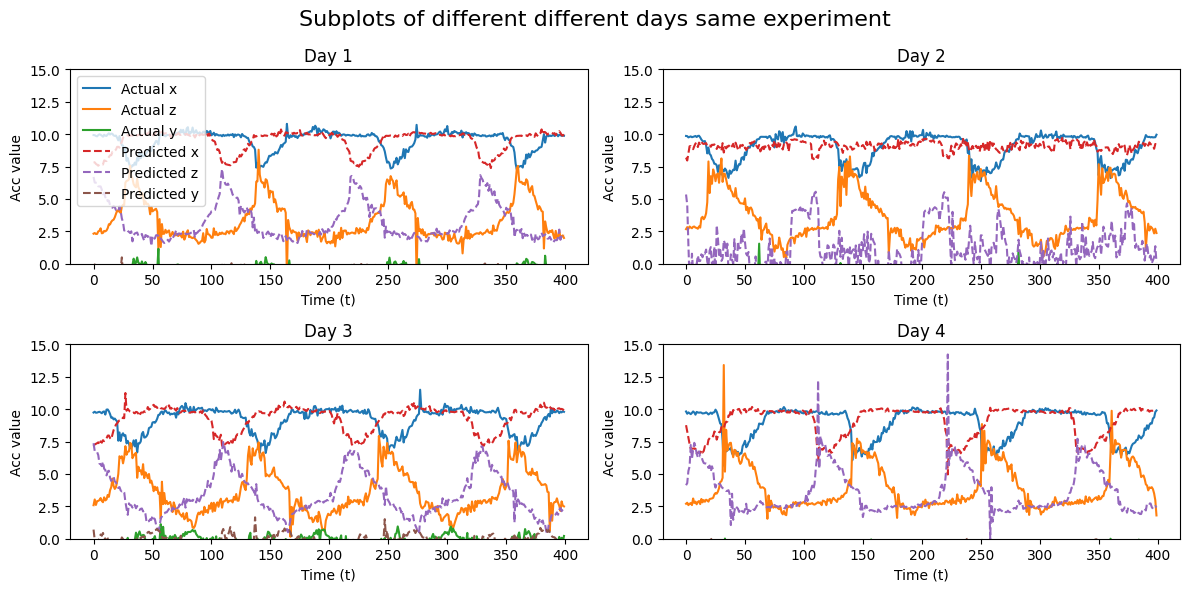

In [12]:
y,yp=getMSEPreds("carpet_d1_raw_L.csv","carpet_d1_raw_R.csv",uber_model,t)

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
axis=[0,1,2]
start=300
show=700
# Plotting each set of x and y data on separate subplots
axs[0,0].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[0,0].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[0,0].set_title('Day 1')
axs[0,0].legend()
axs[0,0].set_ylim([0,15])
axs[0,0].set_xlabel('Time (t)')
axs[0,0].set_ylabel('Acc value')

y,yp=getMSEPreds("carpet_d2_raw_L.csv","carpet_d2_raw_R.csv",uber_model,t)

axs[0,1].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[0,1].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[0,1].set_title('Day 2')
axs[0,1].set_ylim([0,15])
axs[0,1].set_xlabel('Time (t)')
axs[0,1].set_ylabel('Acc value')

y,yp=getMSEPreds("RoughRock_d3_raw_L.csv","RoughRock_d3_raw_R.csv",uber_model,t)

axs[1,0].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[1,0].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[1,0].set_title('Day 3')
axs[1,0].set_ylim([0,15])
axs[1,0].set_xlabel('Time (t)')
axs[1,0].set_ylabel('Acc value')

y,yp=getMSEPreds("carpet_d4_raw_L.csv","carpet_d4_raw_R.csv",uber_model,t)

axs[1,1].plot(y[start:show,axis],label=["Actual x","Actual z","Actual y"])
axs[1,1].plot(yp[start:show,axis],"--",label=["Predicted x","Predicted z","Predicted y"])
axs[1,1].set_title('Day 4')
axs[1,1].set_ylim([0,15])
axs[1,1].set_xlabel('Time (t)')
axs[1,1].set_ylabel('Acc value')

plt.suptitle('Subplots of different different days same experiment', fontsize=16)

plt.tight_layout()
plt.show()


## Foot visualisation 

X data: (3600, 32) /ny data: (3600, 3)
X data: (4950, 32) /ny data: (4950, 3)
0.06060606060606061 %
0.12121212121212122 %
0.18181818181818182 %
0.24242424242424243 %
0.30303030303030304 %
0.36363636363636365 %
0.4242424242424243 %
0.48484848484848486 %
0.5454545454545455 %
0.6060606060606061 %
0.6666666666666667 %
0.7272727272727273 %
0.787878787878788 %
0.8484848484848486 %
0.9090909090909091 %
0.9696969696969697 %
1.0303030303030303 %
1.090909090909091 %
1.1515151515151514 %
1.2121212121212122 %
1.2727272727272727 %
1.3333333333333335 %
1.3939393939393938 %
1.4545454545454546 %
1.5151515151515151 %
1.575757575757576 %
1.6363636363636365 %
1.6969696969696972 %
1.7575757575757573 %
1.8181818181818181 %
1.8787878787878787 %
1.9393939393939394 %
2.0 %
2.0606060606060606 %
2.1212121212121215 %
2.181818181818182 %
2.242424242424242 %
2.3030303030303028 %
2.3636363636363638 %
2.4242424242424243 %
2.484848484848485 %
2.5454545454545454 %
2.6060606060606064 %
2.666666666666667 %
2.72727272727

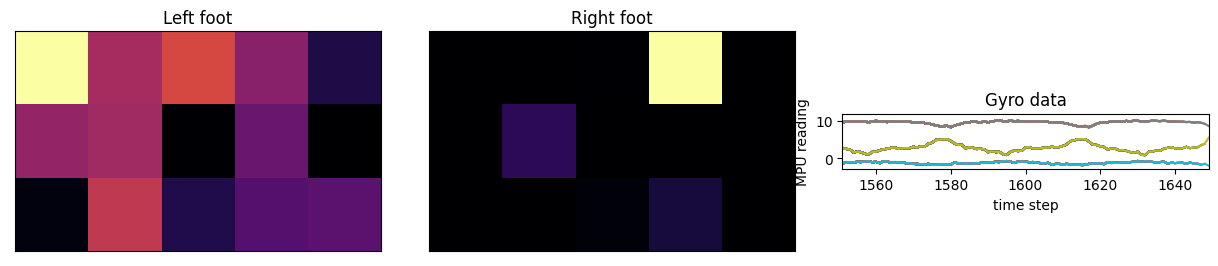

In [33]:
import cv2

def get_foot_image(processed): #get the image of an array
    grid=np.zeros((3,5))
    grid[2][4]=processed[0]
    grid[2][3]=processed[1]
    grid[2][2]=processed[2]
    grid[2][1]=processed[3]
    grid[2][0]=processed[4]

    grid[1][3]=processed[8]
    grid[1][2]=processed[9]
    grid[1][1]=processed[6]
    grid[1][0]=processed[5]

    grid[0][4]=processed[10]
    grid[0][3]=processed[11]
    grid[0][2]=processed[12]
    grid[0][1]=processed[13]
    grid[0][0]=processed[14]
    grid=(grid-np.min(grid))/(np.max(grid)-np.min(grid))
    return grid

def getReductionMatrix(filename):
    x,y=sort_data(filename,vibration=True,dir="all") #loop through file name
    reduction = np.average(x,axis=0)
    return reduction

def genVideo(filename,pathtosave,rd=None):
    #open file
    x,y=sort_data(filename,vibration=True,dir="all") #loop through file name
    #x=(x-np.average(x))/(np.std(x))
    if type(rd)==type(None):
        rd=np.zeros_like(np.average(x,axis=0))
    mean_values = np.mean(x, axis=1, keepdims=True)
    std_dev_values = np.std(x, axis=1, keepdims=True)
    #x = (x - mean_values) / std_dev_values
    x=x-rd
    x[x<0]=0
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    data=[]
    vid_not_started=True
    out=None
    pointer=0
    for _,i in enumerate(range(0,len(x),3)): #len(x)
        ft1=get_foot_image(x[i][:16])
        ft2=get_foot_image(x[i][16:])
        #plot image
        axs[0].imshow(ft1,cmap='inferno')
        axs[0].set_title("Left foot")
        axs[0].xaxis.set_visible(False)
        axs[0].yaxis.set_visible(False)

        axs[1].imshow(ft2,cmap='inferno')
        axs[1].set_title("Right foot")
        axs[1].xaxis.set_visible(False)
        axs[1].yaxis.set_visible(False)
        #plot data
        data.append(y[i])
        #print(np.arange(pointer,i+1).shape,np.array(data)[:,0].shape)
        assert len(np.arange(pointer,_+1))<=100, "incrorrect range size: "+str(_)+","+str(pointer)
        ar=np.array(data)
        axs[2].plot(np.arange(pointer,_+1),ar[:,0])
        axs[2].plot(np.arange(pointer,_+1),ar[:,1])
        axs[2].plot(np.arange(pointer,_+1),ar[:,2])
        axs[2].set_xlabel("time step")
        axs[2].set_ylabel("MPU reading")
        axs[2].set_title("Gyro data")
        axs[2].set_aspect("equal")
        if len(data)>=100:
            pointer=_-98
            axs[2].set_xlim([pointer,_])
            data.pop(0)
        else:
            axs[2].set_xlim([0,100])
        fig.tight_layout(pad=0.05)
        fig.savefig(path+"assets/"+"save"+".png")
        ad=cv2.imread(path+"assets/"+"save"+".png")

        if vid_not_started:
            h1, w1 = ad.shape[:2]
            out = cv2.VideoWriter(pathtosave,cv2.VideoWriter_fourcc(*'DIVX'), 30, (w1,h1))
            vid_not_started=False
        #save figure
        out.write(ad) #uncomment to record video
        if i%5000:
            print(i/len(x) *100,"%")

    out.release()
rd=getReductionMatrix("standing.csv")
genVideo("carpet_d1.1_raw_L.csv",path+"assets/saveLeftNormalised.avi",rd=rd)
#genVideo("carpet_d1.1_raw_R.csv",path+"assets/saveRight.avi")

X data: (3600, 32) /ny data: (3600, 3)
0.08333333333333334 %
0.16666666666666669 %
0.25 %
0.33333333333333337 %
0.4166666666666667 %
0.5 %
0.5833333333333334 %
0.6666666666666667 %
0.75 %
0.8333333333333334 %
0.9166666666666666 %
1.0 %
1.0833333333333335 %
1.1666666666666667 %
1.25 %
1.3333333333333335 %
1.4166666666666665 %
1.5 %
1.5833333333333335 %
1.6666666666666667 %
1.7500000000000002 %
1.8333333333333333 %
1.9166666666666665 %
2.0 %
2.083333333333333 %
2.166666666666667 %
2.25 %
2.3333333333333335 %
2.4166666666666665 %
2.5 %
2.5833333333333335 %
2.666666666666667 %
2.75 %
2.833333333333333 %
2.9166666666666665 %
3.0 %
3.0833333333333335 %
3.166666666666667 %
3.25 %
3.3333333333333335 %
3.4166666666666665 %
3.5000000000000004 %
3.5833333333333335 %
3.6666666666666665 %
3.75 %
3.833333333333333 %
3.916666666666667 %
4.0 %
4.083333333333333 %
4.166666666666666 %
4.25 %
4.333333333333334 %
4.416666666666667 %
4.5 %
4.583333333333333 %
4.666666666666667 %
4.75 %
4.833333333333333 %


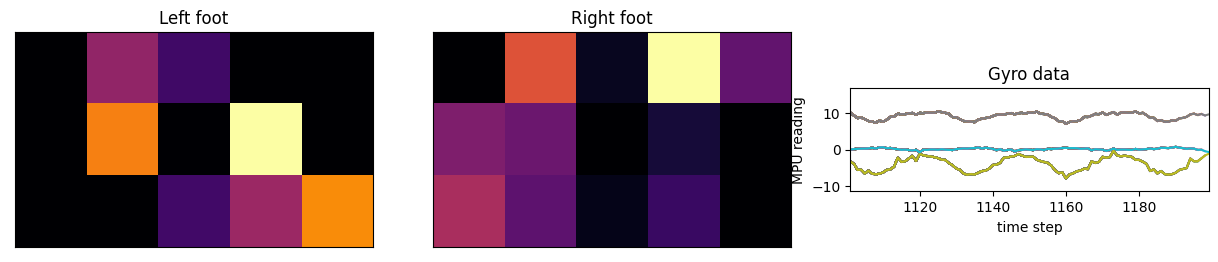

In [35]:
genVideo("carpet_d1.1_raw_R.csv",path+"assets/saveRightNormalised.avi",rd=rd)

In [ ]:
x,y=sort_data("carpet_d1.1_raw_L.csv",vibration=True,dir="all") #loop through file name
x=(x-np.average(x))/(np.std(x))
np.min(x),np.max(x)

#### Signal filtering

In [ ]:


X,y=sort_data("carpet_d1.1_raw_L.csv")

In [6]:
import numpy as np

# Example sensor readings for each sensor
sensor_readings = np.array([
    [10, 20, 30],
    [5, 15, 25],
    [8, 18, 28],
    # Add more rows for additional sensors
])

# Z-Score Normalization
mean_values = np.mean(sensor_readings, axis=1, keepdims=True)
std_dev_values = np.std(sensor_readings, axis=1, keepdims=True)

normalized_sensor_readings = (sensor_readings - mean_values) / std_dev_values

print("Original Sensor Readings:")
print(sensor_readings)
print("\nNormalized Sensor Readings (Z-Score Normalization):")
print(normalized_sensor_readings)


Original Sensor Readings:
[[10 20 30]
 [ 5 15 25]
 [ 8 18 28]]

Normalized Sensor Readings (Z-Score Normalization):
[[-1.22474487  0.          1.22474487]
 [-1.22474487  0.          1.22474487]
 [-1.22474487  0.          1.22474487]]


## Ramp data

(31333, 32) (31333, 3)


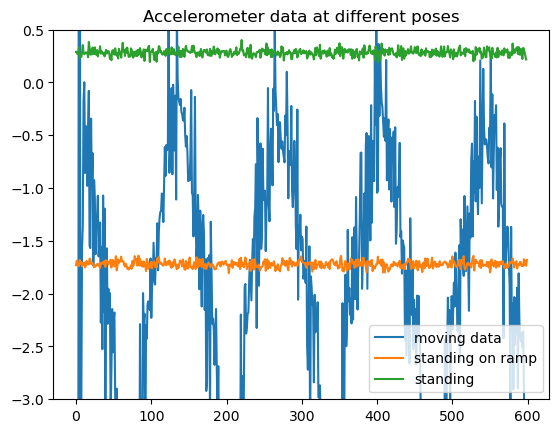

In [39]:
X,y=genDataSet(0,texture=False,days=True,ramp=True,servos=0)
y=y[:,1]
plt.plot(y[0:600],label="moving data")

X,y=getStanding(servos=1)
y=y[:,1]
plt.plot(y[0:600],label="standing on ramp")
plt.plot(y[-600:-1],label="standing")
plt.ylim([-3,0.5])
plt.legend(loc="lower right")
plt.title("Accelerometer data at different poses")
plt.show()

### train regression

Mean Squared Error: 0.00189


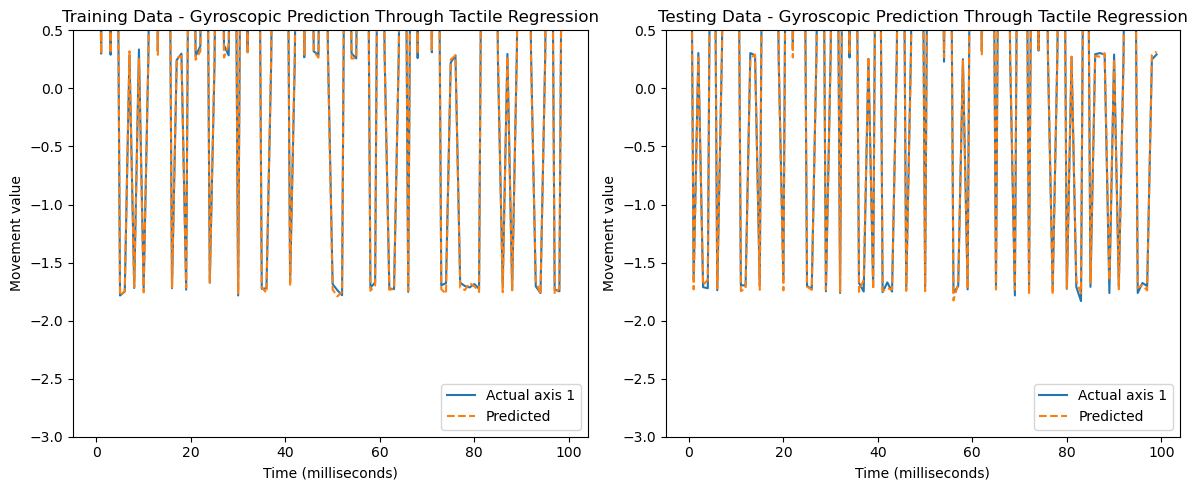

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")
start = 100
end = 200
axis = 1

# Plot for Training Data
Y_pred_train = ridge_model.predict(X_train)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Subplot 1 - Training Data
axs[0].plot(Y_train[start:end], label="Actual axis 1")
axs[0].plot(Y_pred_train[start:end], "--", label="Predicted")

axs[0].set_ylim([-3,0.5])
axs[0].set_title("Training Data - Gyroscopic Prediction Through Tactile Regression")
axs[0].set_ylabel("Movement value")
axs[0].set_xlabel("Time (milliseconds)")
axs[0].legend(loc="lower right")

# Plot for Testing Data
Y_pred_test = ridge_model.predict(X_test)

# Subplot 2 - Testing Data
axs[1].plot(Y_test[start:end], label="Actual axis 1")
axs[1].plot(Y_pred_test[start:end], "--", label="Predicted")


axs[1].set_ylim([-3,0.5])
axs[1].set_title("Testing Data - Gyroscopic Prediction Through Tactile Regression")
axs[1].set_ylabel("Movement value")
axs[1].set_xlabel("Time (milliseconds)")
axs[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


### generlisation

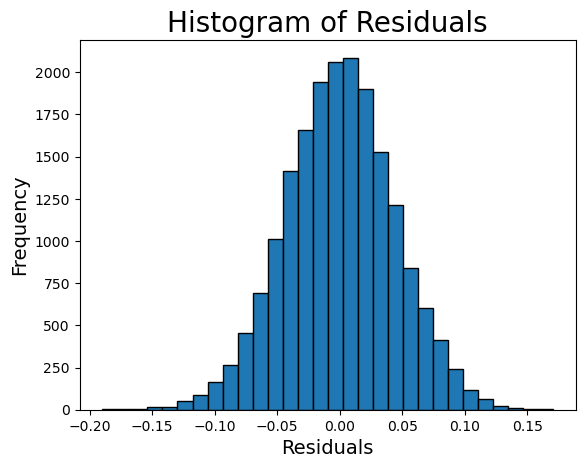

In [55]:
#open data files
X,y=getStanding(servos=1)
y=y[:,1]
pred=ridge_model.predict(X)

#make label for slope interval

# Assuming 'actual_values' and 'predicted_values' are your actual and predicted tilt values
# Calculate the residuals
residuals = y - pred

# Create a histogram of residuals
plt.hist(residuals, bins=30, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Residuals', fontsize=20)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()